In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import joblib
import json

sns.set_style('darkgrid')

# Common Functions

In [2]:
def handle_outliers(df, feature):
    """
    Removes outliers using IQR:

    Q1 - 1.5 * IQR < X < Q3 + 1.5 * IQR

    Returns cleaned data
    """
    df = df[df[feature] > 1]

    q1, q3 = df[feature].quantile(0.25), df[feature].quantile(0.75)
    iqr = q3-q1
    lower_bound, upper_bound = q1 - (1.5 * iqr), q3 + (1.5 * iqr)

    df = df[(df[feature] < upper_bound) & (df[feature] > lower_bound)]

    return df

def select_top_n(df, group_by, feature, n):
    """
    Selects out n categories that are the most significant in given feature
    """
    grouped_sum = df.groupby(group_by)[feature].sum().sort_values(ascending=False)

    indeces = grouped_sum.index

    return indeces[:n]

def model_results(model, X_train, X_test, y_train, y_test):
    """
    Prints model metrics and represents scatterplot of real and predicted values
    """
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    print('TRAIN METRICS')
    print('R2:', r2_score(y_train, y_hat_train),
          '\nMAPE:', mean_absolute_percentage_error(y_train, y_hat_train),
          '\nRMSE:', mean_squared_error(y_train, y_hat_train, squared=False),
          '\nMAE:', mean_absolute_error(y_train, y_hat_train),
          '\n')

    print('TEST METRICS')
    print('R2:', r2_score(y_test, y_hat_test),
          '\nMAPE:', mean_absolute_percentage_error(y_test, y_hat_test),
          '\nRMSE:', mean_squared_error(y_test, y_hat_test, squared=False),
          '\nMAE:', mean_absolute_error(y_test, y_hat_test),
          '\nMAX diff:', np.abs(y_test-y_hat_test).max(),
          '\nMIN diff:', np.abs(y_test-y_hat_test).min())

    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=y_hat_test,
                  y=y_test,
                  s=10)
    plt.title('Residuals')
    plt.xlabel('Y Hat')
    plt.ylabel('Y')
    plt.show()

# Transformers

In [3]:
class CumulativeColumnsConverter(BaseEstimator, TransformerMixin):
    def __init__(self, cumulative_columns):
        self.cumulative_columns = cumulative_columns

    def get_target_columns(self, df, feature):
        """
        Returns sorted list of cummulative columns for feature

        Ex. 
            For total_sessions_day returns:
            [total_sessions_day0, total_sessions_day1, total_sessions_day3, ...]
        """
        cummulative_columns = [col for col in df.columns if feature in col]
        cummulative_columns.sort()

        return cummulative_columns

    def cumulative_to_discrete(self, df, feature, prefix='disc'):
        """
        Appends discrete columns to the df and returns transformed df
        """
        target_cols = self.get_target_columns(df, feature)
        target_cols = [col for col in target_cols if prefix not in col]
        target_cols.sort()
        transformed_cols = []

        for i in reversed(range(len(target_cols))):
            col = target_cols[i]
            new_col = f'{prefix}_{col}'

            if i == 0:
                df[new_col] = df[col]
            else:
                prev_col = target_cols[i - 1]
                df[new_col] = df[col] - df[prev_col] 

            transformed_cols.append(new_col)

        df = df.drop(columns=target_cols)

        return df

    def get_cumulative(self, df):
        cumulative_columns = set()
        
        for col in df.columns:
            if col[-1].isdigit() and 'retained' not in col and 'target' not in col and 'disc' not in col:
                cumulative_columns.add(col[:-1])

        return list(cumulative_columns)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cumulative_columns = self.get_cumulative(X)

        for col in cumulative_columns:
            X = self.cumulative_to_discrete(X, col)

        return X

class CastToTypes(BaseEstimator, TransformerMixin):
    def __init__(self, column_types):
        self.column_types = column_types

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.astype(self.column_types)
        return X

class ColumnsSortingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X[sorted(list(X.columns))]
        self.columns = X.columns
        return X

    def get_feature_names(self):
        return self.columns

class RedundantRemover(BaseEstimator, TransformerMixin):
    def __init__(self, redundant_columns):
        self.redundant_columns = redundant_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for col in self.redundant_columns:
            if col in X.columns:
                X = X.drop(columns=[col])
        return X

class UnpopularCategoriesMerger(BaseEstimator, TransformerMixin):
    def __init__(self, top_categories):
        """
        top_categories represents a dictionary with category and top categories

        {'country_code': ['COUNTRY_141', 'COUNTRY_155', ...],
         'media_source': ['SOURCE_17', 'SOURCE_23', ...]}
        """
        self.top_categories = top_categories

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for category in self.top_categories:
            X[category] = X[category].apply(lambda cat:
                                        cat if cat in self.top_categories[category]
                                            else f'OTHER_{category.upper()}')
        return X

class CustomOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, categories):
        self.categories = categories

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for category in self.categories:
            oh_col = pd.get_dummies(X[category])
            X = X.drop(category, axis=1)
            X = X.join(oh_col)
            X[oh_col.columns] = X[oh_col.columns].astype('int64')

        return X

class CategoryFiller(BaseEstimator, TransformerMixin):
    def __init__(self, top_categories):
        self.top_categories = top_categories

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for top_cat in self.top_categories.values():
            for cat in top_cat:
                if cat not in X.columns:
                    X[cat] = 0

        for cat in self.top_categories.keys():
            cat = f'OTHER_{cat.upper()}'
            if cat not in X.columns:
                    X[cat] = 0

        return X

class NullImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.fillna(0)
        return X

# ML Pipeline

In [4]:
def split_data(data, denoised_data, insolvent_size, target_name, full=False):
    """
    Splits data on the train and test sets
    """
    data = data[~data.isin(denoised_data)].dropna()
    if not full:
        data = data.sample(insolvent_size)

    data = data[denoised_data.columns]

    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[target_name]),
                                                        data[target_name], test_size=0.1)

    X_train_denoised, X_test_denoised, y_train_denoised, y_test_denoised = train_test_split(
                                                        denoised_data.drop(columns=[target_name]),
                                                        denoised_data[target_name], test_size=0.1
                                                        )

    X_train, y_train = X_train.append(X_train_denoised), y_train.append(y_train_denoised)
    X_test, y_test = X_test.append(X_test_denoised), y_test.append(y_test_denoised)

    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train, X_test, y_test, column_types,
               categorical_columns, numerical_columns, cumulative_columns, redundant_columns,
               top_categories, model_args=None, estimator_name='xgb'):
    """
    Whole Pipeline and training
    Returns ready to use model
    """
    if not model_args:
        model_args = {
                        'learning_rate': .2,
                        'n_estimators': 300,
                        'max_depth': 11,
                        'gamma': 0.4,
                        'eval_metric': "mae"
                }

    if estimator_name == 'xgb':
        estimator = XGBRegressor(**model_args)
    else:
        estimator = RandomForestRegressor(**model_args)

    model = Pipeline(steps=[
        ("remove_redandant", RedundantRemover(redundant_columns)),
        ("merge_unpopular_categories", UnpopularCategoriesMerger(top_categories)),
        ("cumulative_to_discrete", CumulativeColumnsConverter(cumulative_columns)),
        ("cast_to_correct_types", CastToTypes(column_types)),
        ("one_hot_encoding", CustomOneHot(list(top_categories.keys()))),
        ("category_filling", CategoryFiller(top_categories)),
        ("columns_sorting", ColumnsSortingTransformer()),
        ("null_imputing", NullImputer()),
        ("estimator", estimator)])
    
    if estimator_name == 'rf':
        model = model.fit(X_train, y_train)
        return model

    temp_pipe = Pipeline(model.steps[:-1])
    temp_pipe.fit_transform(X_train, y_train)

    eval_set = [(temp_pipe.transform(X_test), y_test)]
    temp_pipe.steps.append(model.steps[-1])
    model = temp_pipe

    model = model.fit(X_train, y_train,
                     estimator__early_stopping_rounds=10, 
                     estimator__eval_set=eval_set,
                     estimator__verbose=False)

    return model

def model_metrics(model, X, y):
    """
    Returns a dictionary with MAPE, MAE and RMSE
    """
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    rmse = mean_squared_error(y, preds, squared=False)

    metrics = {
        'mae': mae,
        'mape': mape,
        'rmse': rmse
    }

    return metrics

def predict(sample):
    """
    Predicts sample based on platform type
    """
    ios = sample[sample['platform'] == 'ios']
    android = sample[sample['platform'] == 'android']
    
    ios_model = joblib.load('ios/model.pkl')
    android_model = joblib.load('android/model.pkl')

    y_hat_ios, y_hat_android = ios_model.predict(ios), android_model.predict(android)

    sample['Y'] = 0

    sample.loc[sample['platform'] == 'ios', 'Y'] = np.maximum(y_hat_ios, 0)
    sample.loc[sample['platform'] == 'android', 'Y'] = np.maximum(y_hat_android, 0)

    return sample['Y']

def mean_scores(ios_scores, android_scores):
    """
    Returns average scores of 2 models
    """
    scores = {}

    for metric in ios_scores.keys():
        metric_ios = ios_scores[metric]
        metric_android = android_scores[metric]

        scores[metric] = round((metric_ios + metric_android) / 2, 4)

    return scores

def interpret_xgb(pipeline, n=40):
    """
    Plots feature importance of XGBoost model
    """
    model = pipeline[-1]
    feature_importance = model.get_booster().get_score(importance_type='weight')
    features = list(feature_importance.keys())
    scores = list(feature_importance.values())

    data = pd.DataFrame(data=scores, index=features, columns=["score"]).sort_values(by="score", ascending=True)
    data.nlargest(n, columns="score").plot(kind='barh', figsize=(20,10), color='darkslateblue')

    plt.title(f'Feature Importance (Top {n} Features)')
    plt.show()

def interpret_random_forest(pipeline, n=40):
    """
    Plots feature importance of Random Forest model
    """
    rf = model_android.steps[-1][1]

    features = pipeline.steps[-2][1].get_feature_names()
    scores = rf.feature_importances_

    data = pd.DataFrame(data=scores, index=features, columns=["score"]).sort_values(by="score", ascending=True)
    data.nlargest(n, columns="score").plot(kind='barh', figsize=(20,10), color='darkslateblue')

    plt.title(f'Feature Importance (Top {n} Features)')
    plt.show()

def main(platform, model_args=None, estimator_name='xgb'):
    # TARGETS
    TARGET = 'target_full_ltv_day30'
    SUBTARGETS = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']
    TO_DROP = ['platform', 'install_date'] + SUBTARGETS

    # Train/Test Datasest Loading
    data_path = 'dataset.csv'
    full_data = pd.read_csv(data_path).drop(columns=TO_DROP).fillna(0)
    denoised_data = handle_outliers(full_data, TARGET)

    insolvent_size = 100000

    X_train, X_test, y_train, y_test = split_data(full_data, denoised_data, insolvent_size, TARGET, full=False)

    # Features determination
    categorical_columns = ['country_code', 'media_source']
    redundant_columns = ['install_date', 'platform'] + SUBTARGETS + TO_DROP + [TARGET]
    numerical_columns = []

    cumulative_columns = [
                            'app_sub_ltv_day', 'app_iap_ltv_day', 'ad_ltv_day',
                            'chapters_finished_day', 'chapters_opened_day', 'chapters_closed_day', 'diamonds_received_day',
                            'diamonds_spent_day', 'tickets_spent_day', 'tickets_spent_session',
                            'diamonds_spent_session', 'total_sessions_day', 'chapters_finished_session',
                            'chapters_opened_session', 'chapters_closed_session'
                        ]

    column_types = {}

    for col in X_train.columns:
        if col[:-1] in cumulative_columns:
            col = 'disc_' + col
        if col in categorical_columns:
            column_types[col] = str
        else:
            numerical_columns.append(col)
            column_types[col] = int

    top_categories = {"country_code": [],
                      "media_source": []}
    top_number = [10, 5]
    # Select top n among all categories based on TARGET value
    for category, n in zip(top_categories.keys(), top_number):
        top_categories[category] = select_top_n(full_data, category, TARGET, n)

    model = train_model(X_train, y_train, X_test, y_test, column_types,
               categorical_columns, numerical_columns, cumulative_columns, redundant_columns, top_categories,
               model_args=model_args, estimator_name=estimator_name)

    joblib.dump(value=model, filename=f'{platform}/model.pkl')

    model_results(model, X_train, X_test, y_train, y_test)
    scores = model_metrics(model, X_test, y_test)

    return model, scores

TRAIN METRICS
R2: 0.933046890940391 
MAPE: 62843723530453.31 
RMSE: 0.8137104614216457 
MAE: 0.32009902117024625 

TEST METRICS
R2: 0.8462725456943113 
MAPE: 62208966229049.164 
RMSE: 1.0944292110214677 
MAE: 0.38313388672749976 
MAX diff: 47.5769747392814 
MIN diff: 1.814653804630968e-05


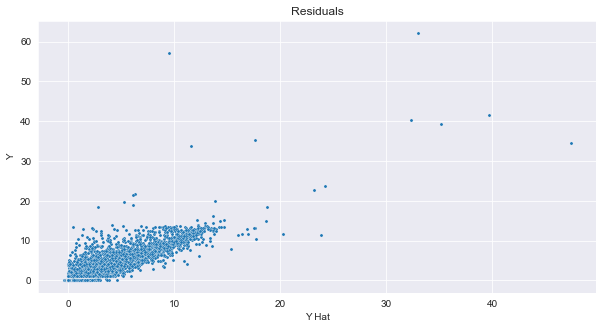

In [5]:
model_args_ios = {
                        'n_estimators': 1000,
                        'min_child_weight': 5,
                        'max_depth': 9,
                        'learning_rate': 0.2285714285714286,
                        'reg_lambda': 2,
                        'reg_alpha': 0.2,
                        'gamma': 1,
                        'colsample_bytree': 0.7999999999999999
                }

model_ios, scores_ios = main('ios', model_args=model_args_ios, estimator_name='xgb')

TRAIN METRICS
R2: 0.9229768109301967 
MAPE: 74871052600801.31 
RMSE: 0.8238018592343872 
MAE: 0.3354623577331165 

TEST METRICS
R2: 0.847843714001923 
MAPE: 83215266365535.95 
RMSE: 1.118952615057733 
MAE: 0.41560354308916025 
MAX diff: 40.50875069626544 
MIN diff: 0.00012989580665755227


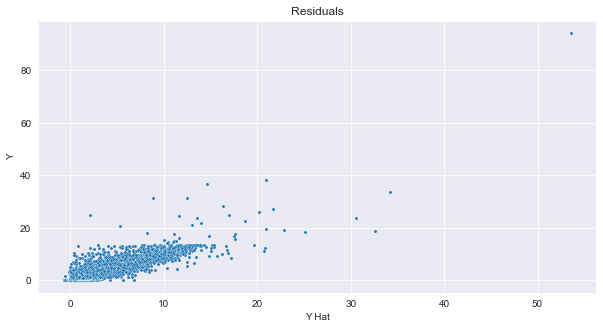

In [6]:
model_args_android = {
        'n_estimators': 1100,
        'min_child_weight': 1,
        'max_depth': 9,
        'learning_rate': 0.3571428571428572,
        'reg_lambda': 2,
        'reg_alpha': 0.2,
        'gamma': 3,
        'colsample_bytree': 0.6
}

model_android, scores_android = main('android', model_args=model_args_android, estimator_name='xgb')

# Target Metric

As for target metric we have chosen $RMSE$

$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(X_i -\hat{X_i}\Big)^2}}$

Since it penalizes difference between real and predicted values more. However, $MAE$ seems to be a good metric as well:

$MAE = \frac{1}{n}\Sigma_{i=1}^{n}{\Big|X_i -\hat{X_i}\Big|^2}$

$MAPE$ is not a proper choice, because distribution of our target variable has a high density in 0. Thus, $MAPE$ will produce strange numbers, because of zero division.

$MAPE = \frac{1}{n}\Sigma_{i=1}^{n}{\Big|\frac{X_i -\hat{X_i}}{X_i}\Big|^2}$

# Interpretation
Here we may observe that some features hold more weights for our target value. For example, we can understand that it is highly important for user to spend **diamonds** to be pron to donate or watch advert and bring more income to company. All features are sorted by their importance scores, where the higher score is, the more feature important for us.

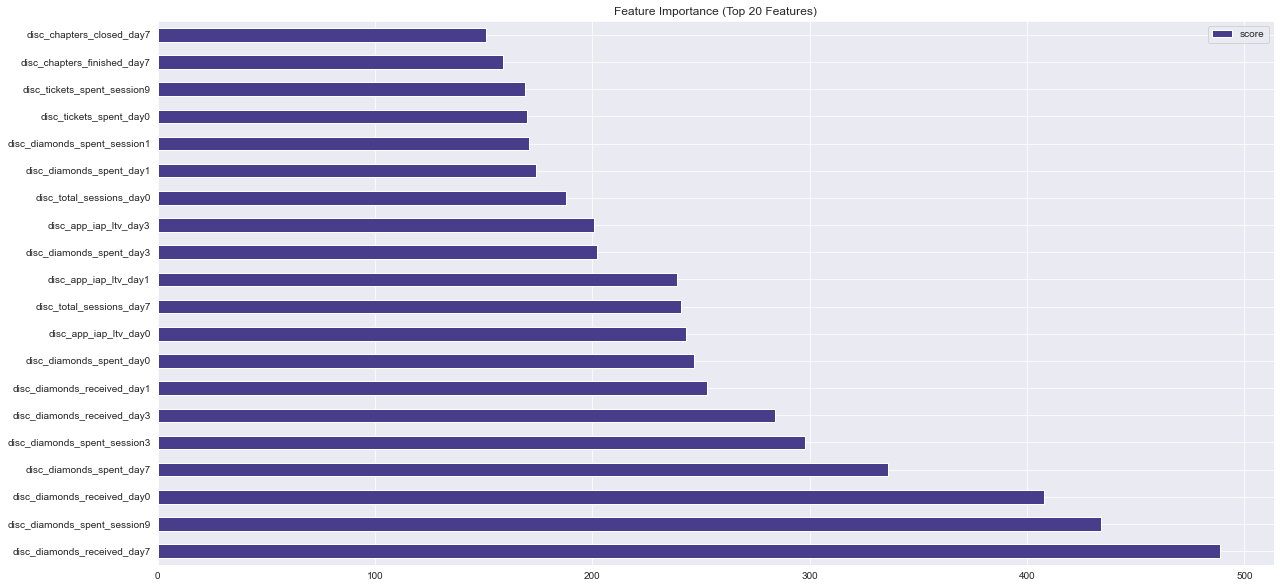

In [7]:
interpret_xgb(model_ios, 20)

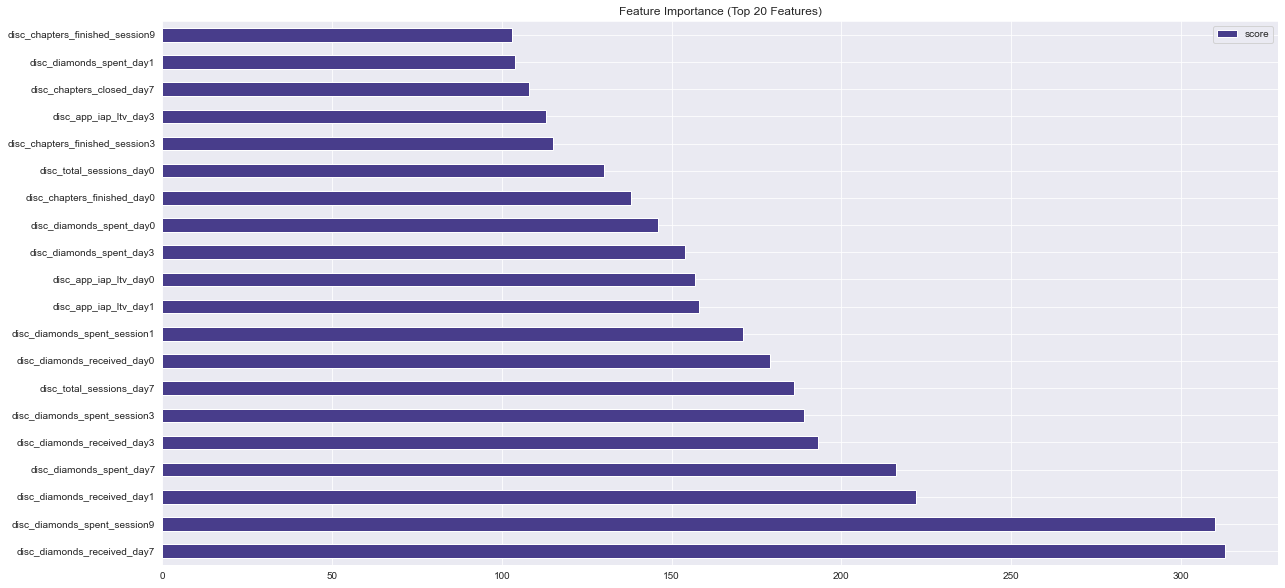

In [8]:
interpret_xgb(model_android, 20)

# Final metrics
Metrics obtained are the following. They are totally unbiased, because in the test set included samples with both solvent and insolvent users, where target values range is high (100-200).

In [14]:
scores = mean_scores(scores_ios, scores_android)
json.dump(scores, open('metrics.json', 'w'))

for metric, score in scores.items():
    print(f'{metric.upper()}: {score}')

MAE: 0.3994
MAPE: 72712116297292.56
RMSE: 1.1067


# Usage
We can simply pass our sample data in predict function and get an array with results

In [11]:
data_path = 'dataset.csv'
df = pd.read_csv(data_path)
sample = df.sample(10)

print('PREDICTED\n', list(predict(sample)), '\nREAL\n', list(sample['target_full_ltv_day30']))

PREDICTED
 [0.0, 0.03603121638298035, 0.0194570180028677, 0.02330384962260723, 2.287957191467285, 0.0, 0.0011754212900996208, 1.230774998664856, 0.11188013851642609, 0.0] 
REAL
 [0.0, 0.0006061760730696012, 0.0, 0.0, 6.948128615254142, 0.03595166535110434, 0.0, 0.08332781421189389, 0.0, 0.0]
